In [92]:
from voidiness import voidy_analysis
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [93]:
# 12m 36.6s seconds to run. WOW
# filtered_sdss_dr16 = voidy_analysis('exported_dataFrames/voids.xlsx','exported_dataFrames/z_ra_dec_filtered_SDSS_DR16.xlsx') # commented out since its saved and it takes 13 minutes to run
# Saving so i don't have to wait 13 minutes for it to calculate
# This also takes 1m 35s to save. wow
# filtered_sdss_dr16.to_excel('exported_dataFrames/sdss_dr16_w_voidiness.xlsx')

sdss_dr16 = pd.read_excel('exported_dataFrames/sdss_dr16_w_voidiness.xlsx')


In [102]:

four_lac = voidy_analysis('exported_dataFrames/voids.xlsx','exported_dataFrames/z_ra_dec_filtered_4lac.xlsx' )
xray_agns = voidy_analysis('exported_dataFrames/voids.xlsx', 'exported_dataFrames/z_ra_dec_filtered_xray_agns.xlsx' )
soft_xrays = voidy_analysis('exported_dataFrames/voids.xlsx','exported_dataFrames/z_ra_dec_filtered_ROMABZCAT.xlsx' )

In [95]:
# Base plotting code, the only thing we tweak is the data we're plotting.
# The bins and label

def custom_plot_hist(data, labels, bins, density=None):

    if density == None:
        density = [True]*len(data)
        
    for dat, label, bin in zip(data, labels, bins):
        plt.hist([dat], 
            bins=bin, 
            histtype="step", 
            density=density, 
            stacked=False,
            label=label)
        
    plt.xlabel('Voidiness [$D_{\\rm Void}/D_{\\rm Total}$]')
    plt.ylabel('Normalized Fraction')
    plt.title('Voidiness Histogram')

    plt.grid()

    plt.legend()

    plt.text(0.5, 0.5, 'Preliminary',  # Adjust the position as needed
                fontsize=30, color='gray', alpha=0.5,
                ha='center', va='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()


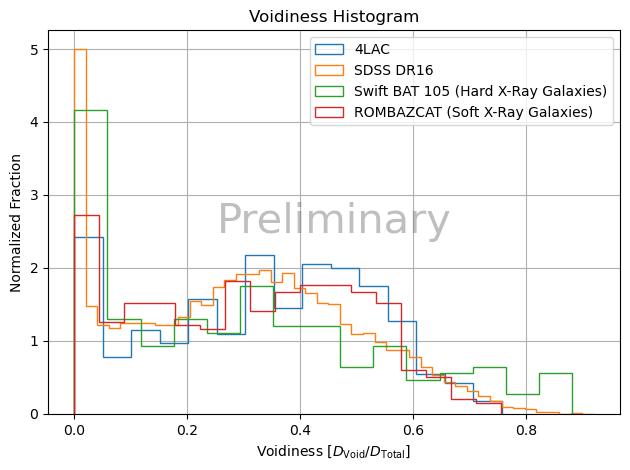

In [105]:
# Everything to be plotted on the histogram will be appended to the master lisst
# if something needs to be changed for a specific histogram, edit the relavent 
# bit of code
VOIDINESS_DATA = [] # list of panda series with voidiness data.
LABELS = []
BINS = []
# density = []

# 4LAC DATA
VOIDINESS_DATA.append(four_lac.Voidiness)
LABELS.append("4LAC")
BINS.append(15)
# density.append(True)

# SDSS DR16 Optical Galaxies
VOIDINESS_DATA.append(sdss_dr16.Voidiness)
LABELS.append("SDSS DR16")
BINS.append(45)
# density.append(True)

# SDSS DR16 Optical Galaxies
VOIDINESS_DATA.append(xray_agns.Voidiness)
LABELS.append("Swift BAT 105 (Hard X-Ray Galaxies)")
BINS.append(15)

# Soft xrays ROMBAZCAT
VOIDINESS_DATA.append(soft_xrays.Voidiness)
LABELS.append("ROMBAZCAT (Soft X-Ray Galaxies)")
BINS.append(17)

custom_plot_hist(VOIDINESS_DATA, LABELS, BINS)


In [106]:
len(soft_xrays)

445

In [97]:
# Clean the data in the SED_class
for idx in list(four_lac.index):
    data = four_lac.SED_class[idx]
    if type(data) == str:
        four_lac.at[idx, 'SED_class'] = data[2:5] # Grabs the 3 characters, HSP ISP, LSP
# Plottinf just the 4lac distribution then filter by SED_class
# Since the data mixes strings with np.nans i need to do somthing a little messier
hsp_list = []
isp_list = []
lsp_list = []
nan_list = []
for i, _ in four_lac.iterrows():
    dat = four_lac.SED_class[i]
    if type(dat) == str:
        if dat == 'HSP':
            hsp_list.append(i)
        elif dat == 'ISP':
            isp_list.append(i)
        elif dat == 'LSP':
            lsp_list.append(i)
        else:
            Exception(f'Something went wrong. Dat = {dat}')
    elif np.isnan(dat): # last check to be sure
        nan_list.append(i)
    else:
        TypeError

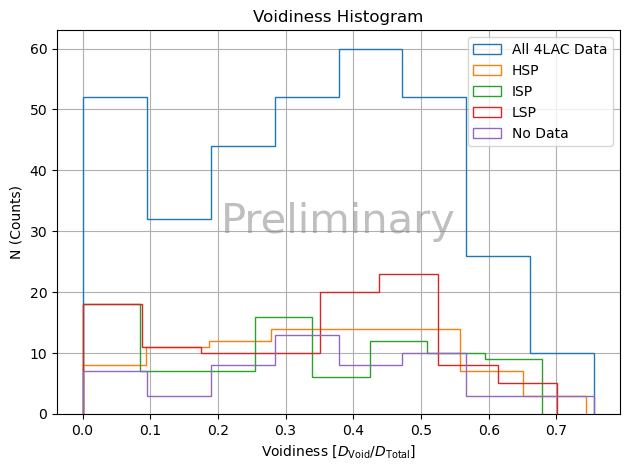

In [98]:
# Unormalized
plt.hist([four_lac.Voidiness], 
    bins=8, 
    histtype="step", 
    density=False, 
    stacked=False,
    label='All 4LAC Data')

plt.hist([four_lac.Voidiness[hsp_list]], 
    bins=8, 
    histtype="step", 
    density=False, 
    stacked=False,
    label='HSP')

plt.hist([four_lac.Voidiness[isp_list]], 
    bins=8, 
    histtype="step", 
    density=False, 
    stacked=False,
    label='ISP')
    
plt.hist([four_lac.Voidiness[lsp_list]], 
    bins=8, 
    histtype="step", 
    density=False, 
    stacked=False,
    label='LSP')

plt.hist([four_lac.Voidiness[nan_list]], 
    bins=8, 
    histtype="step", 
    density=False, 
    stacked=False,
    label='No Data')

plt.xlabel('Voidiness [$D_{\\rm Void}/D_{\\rm Total}$]')
plt.ylabel('N (Counts)')
plt.title('Voidiness Histogram')

plt.grid()

plt.legend()

plt.text(0.5, 0.5, 'Preliminary',  # Adjust the position as needed
            fontsize=30, color='gray', alpha=0.5,
            ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()


In [80]:
# Curve fit
# https://faculty1.coloradocollege.edu/~sburns/LinearFitting/SimpleDataFittingWithError.html
# According to this we should use sigma=True since our data 
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def linear_model(x, a, b):
    return a * x + b

popt, pcov = curve_fit(linear_model, four_lac.Voidiness, four_lac.Flux1000, sigma=four_lac.Unc_Flux1000)
slope, intercept = popt
four_lac['Flux1000_FIT'] = linear_model(np.array(four_lac.Voidiness), slope, intercept)
stats_data = {'Flux1000_FIT_slope': slope, 'Flux1000_FIT_r2': r2_score(four_lac.Flux1000, four_lac.Flux1000_FIT)}


popt, pcov = curve_fit(linear_model, four_lac.Voidiness, four_lac.Energy_Flux100, sigma=four_lac.Unc_Energy_Flux100)
slope, intercept = popt
four_lac['Energy_Flux100_FIT'] = linear_model(np.array(four_lac.Voidiness), slope, intercept)
stats_data['Energy_Flux100_FIT_slope'] = slope
stats_data['Energy_Flux100_FIT_r2'] = r2_score(four_lac.Energy_Flux100, four_lac.Energy_Flux100_FIT)

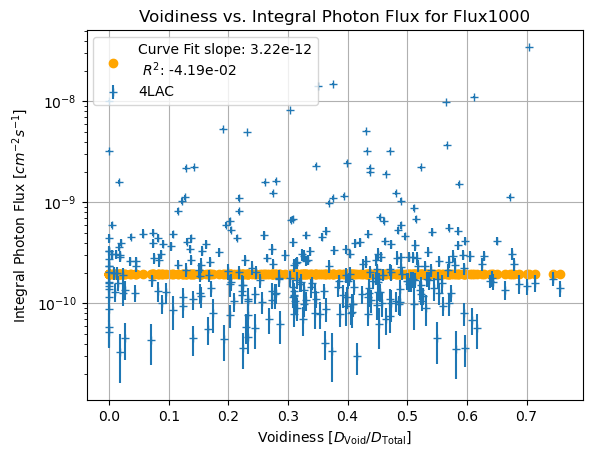

In [89]:
# GRS ONly
# """Voidines v. Power Law Index PL_Index
# Voidiness v. Flux
# """
key = "Flux1000"
plt.errorbar(four_lac.Voidiness, four_lac[key], 
             yerr=four_lac["Unc_"+key],
             linestyle='',
             marker='+',
             label='4LAC')
plt.scatter(four_lac.Voidiness, four_lac[key+"_FIT"], color='orange', label = f"Curve Fit slope: {stats_data[key + '_FIT_slope']:.2e}\n $R^2$: {stats_data[key + '_FIT_r2']:.2e}")
plt.yscale('log')
plt.title(f'Voidiness vs. Integral Photon Flux for {key}')
plt.xlabel("Voidiness [$D_{\\rm Void}/D_{\\rm Total}$]")
plt.ylabel("Integral Photon Flux [$cm^{-2} s^{-1}$] ")
plt.grid()
plt.legend()

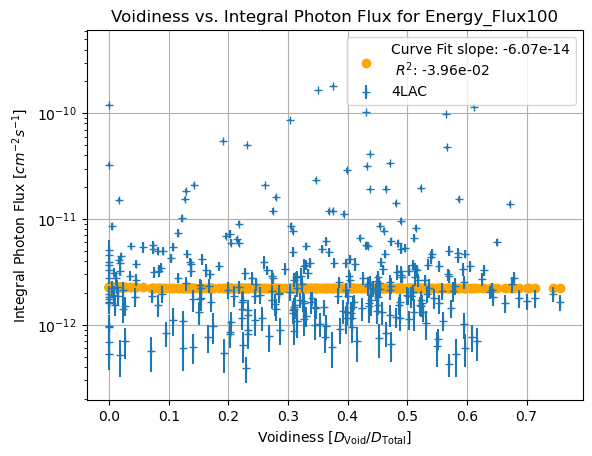

In [88]:
key = "Energy_Flux100"
plt.errorbar(four_lac.Voidiness, four_lac[key], 
             yerr=four_lac["Unc_"+key],
             linestyle='',
             marker='+',
             label='4LAC')
plt.scatter(four_lac.Voidiness, four_lac[key+"_FIT"], color='orange', label = f"Curve Fit slope: {stats_data[key + '_FIT_slope']:.2e}\n $R^2$: {stats_data[key + '_FIT_r2']:.2e}")
plt.yscale('log')
plt.title(f'Voidiness vs. Integral Photon Flux for {key}')
plt.xlabel("Voidiness [$D_{\\rm Void}/D_{\\rm Total}$]")
plt.ylabel("Integral Photon Flux [$cm^{-2} s^{-1}$] ")
plt.grid()
plt.legend()
# TODO: SEPERATE INTO 2 POPULATION BY TEV VS. NON TEV

In [ ]:
# TODO: 